In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import glob
from collections import defaultdict
import pandas as pd

TRAIN_DATA_DIR = '/kaggle/input/inaturalist12k/Data/inaturalist_12K/train'
VAL_DATA_DIR = '/kaggle/input/inaturalist12k/Data/inaturalist_12K/val'

image_list = []

train_paths = {}
val_paths = {}

for label in os.listdir(TRAIN_DATA_DIR):
    cur_path = os.path.join(TRAIN_DATA_DIR, label)
    for filename in glob.glob(f'{cur_path}/*.jpg'):
        train_paths[filename] = label

for label in os.listdir(VAL_DATA_DIR):
    cur_path = os.path.join(VAL_DATA_DIR, label)
    for filename in glob.glob(f'{cur_path}/*.jpg'):
        val_paths[filename] = label

train_df = pd.DataFrame(list(train_paths.items()), columns= ["path", "label"])
val_df = pd.DataFrame(list(val_paths.items()), columns= ["path", "label"])
train_df.to_csv('train.csv', index = False)
val_df.to_csv('val.csv', index = False)

In [3]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class N12KDATA(Dataset):
    def __init__(self, csv_data, image_size=(224, 224), normalize=True, data_augmentation=False):
        self.data = csv_data
        self.image_size = image_size

        # Label Encoding (Mapping labels to indices)
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.data["label"].unique()))}
        self.data["encoded_label"] = self.data["label"].map(self.label_map)

        # Define transformations
        self.transform = self._get_transforms(normalize, data_augmentation)

    def _get_transforms(self, normalize, data_augmentation):
        transform_list = []

        if data_augmentation:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),    # Randomly flip images
                transforms.RandomRotation(10),       # Rotate within ±10 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust color properties
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)) # Random crop and resize
            ])
        else:
            transform_list.append(transforms.Resize(self.image_size))  # Just resize for non-augmented images
        
        transform_list.append(transforms.ToTensor())

        if normalize:
            transform_list.append(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))

        return transforms.Compose(transform_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row["path"]
        label = row["encoded_label"]

        # Load image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class CNNModel(nn.Module):
    def __init__(self, input_shape, num_filters, kernel_size, filter_multiplier, activation, dropout_rate, use_batchnorm, dense_units):
        super(CNNModel, self).__init__()
        
        self.input_shape = input_shape
        self.layers = nn.ModuleList()
        self.num_classes = 10
        self.activation = activation
        self.multiplier = filter_multiplier # takes values like 0.5, 2, 1, 3
        in_channels = input_shape[0]  # Number of input channels (C)
        
        for i in range(5):
            self.layers.append(nn.Conv2d(in_channels, num_filters, kernel_size = kernel_size, padding = kernel_size//2))
            if use_batchnorm:
                self.layers.append(nn.BatchNorm2d(num_filters))  # Apply batch normalization if enabled
            self.layers.append(self._get_activation())
            self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layers.append(nn.Dropout(dropout_rate))
            in_channels = num_filters
            num_filters= int(num_filters*self.multiplier)
            
        # Flatten layer
        self.flatten = nn.Flatten()

        # Compute the output size after convolutions and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            for layer in self.layers:
                dummy_input = layer(dummy_input)
            self.flattened_size = dummy_input.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, dense_units)
        self.fc_activation = self._get_activation() 
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(dense_units, self.num_classes)

    def _get_activation(self):
        if self.activation.lower() == 'relu':
            return nn.ReLU()
        elif self.activation.lower() == 'leaky_relu':
            return nn.LeakyReLU()
        elif self.activation.lower() == 'silu':
            return nn.SiLU()
        elif self.activation.lower() == 'mish':
            return nn.Mish()
        elif self.activation.lower() == 'gelu':
            return nn.GELU()
        else:
            return nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc_activation(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

    def summary(self, batch_size=1):
        """Prints the model summary"""
        return summary(self, input_size=(batch_size, *self.input_shape), col_names=["input_size", "output_size", "num_params", "mult_adds"])


In [36]:
model = CNNModel(
    input_shape=(3, 224, 224),
    num_filters=16,
    kernel_size=5,
    filter_multiplier=0.5,
    activation='ReLU',
    dropout_rate=0.3,
    use_batchnorm=True,
    dense_units=2048
)
print(model.summary(batch_size=8))


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
CNNModel                                 [8, 3, 224, 224]          [8, 10]                   --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Conv2d: 2-1                       [8, 3, 224, 224]          [8, 16, 224, 224]         1,216                     488,112,128
│    └─BatchNorm2d: 2-2                  [8, 16, 224, 224]         [8, 16, 224, 224]         32                        256
│    └─ReLU: 2-3                         [8, 16, 224, 224]         [8, 16, 224, 224]         --                        --
│    └─MaxPool2d: 2-4                    [8, 16, 224, 224]         [8, 16, 112, 112]         --                        --
│    └─Dropout: 2-5                      [8, 16, 112, 112]         [8, 16, 112, 112]         --                        --
│    └─

In [5]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit

def get_data_loaders(train_csv_path, test_csv_path, val_split_ratio = 0.2, normalize = True, data_augmentation = False, seed = 10):
    # Define batch size
    BATCH_SIZE = 64

    # Load the full train CSV
    train_csv = pd.read_csv(train_csv_path)
    labels = train_csv['label'].values

    # Stratified Split such that each class is equally represented in the validation data
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_split_ratio, random_state=seed)
    train_idx, val_idx = next(splitter.split(train_csv, labels))
    
    train_df = train_csv.iloc[train_idx].reset_index(drop=True)
    val_df = train_csv.iloc[val_idx].reset_index(drop=True)

    print(val_df['label'].value_counts())

    # Prepare the Datasets
    train_dataset = N12KDATA(train_df, normalize = normalize, data_augmentation=data_augmentation)
    val_dataset = N12KDATA(val_df, normalize = normalize, data_augmentation=False)
    test_data = pd.read_csv(test_csv_path)
    test_dataset = N12KDATA(test_data, normalize = normalize, data_augmentation=False) 

    # Prepare train, val, test loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, train_dataset.label_map


label
Arachnida    200
Reptilia     200
Aves         200
Mammalia     200
Mollusca     200
Amphibia     200
Fungi        200
Plantae      200
Animalia     200
Insecta      200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Sample image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([64])
One label value: 0


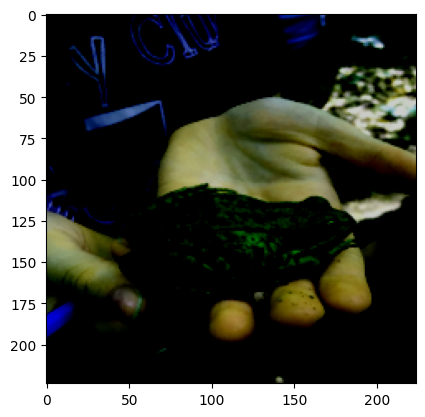

In [6]:
import matplotlib.pyplot as plt
train_loader, val_loader, test_loader, _ = get_data_loaders('/kaggle/working/train.csv', '/kaggle/working/val.csv', data_augmentation = True)
sample_batch = next(iter(train_loader))
images, labels = sample_batch
sample_image = images[0]
print("Sample image shape:", sample_image.shape)
print(f"Labels shape: {labels.shape}")   # Should be [B]
print(f"One label value: {labels[0]}")   # Should be an int tensor
plt.imshow(sample_image.permute(1, 2, 0).cpu().numpy())
plt.show()


In [6]:
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs, lr, device, wandb_logging=False):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Epoch {epoch}/{epochs}] Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total

        print(f"Epoch {epoch:02d}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
        if wandb_logging:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })

In [37]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "num_filters": {"values": [32, 64, 128]},
        "filter_multiplier": {"values": [0.5, 1, 2]},
        "kernel_size": {"values": [3, 5]},
        "activation": {"values": ["relu", "leaky_relu", "gelu", "silu", "mish"]},
        "dropout_rate": {"values": [0.2, 0.5, 0.7]},
        "use_batchnorm": {"values": [True, False]},
        "dense_units": {"values": [512, 1024, 2048]},
        "data_augmentation": {"values": [True, False]},
        "lr": {"values": [0.01, 0.001, 0.0001]},
    }
}

In [41]:
import wandb

def make_run_name(config):
    return (
        f"nf_{config['num_filters']}_"
        f"ks_{config['kernel_size']}_"
        f"fm_{config['filter_multiplier']}_"
        f"act_{config['activation']}_"
        f"do_{config['dropout_rate']}_"
        f"bn_{config['use_batchnorm']}_"
        f"da_{config['data_augmentation']}_"
        f"lr_{config['lr']}_"
        f"du_{config['dense_units']}"
    )


def wandb_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = make_run_name(config)
        print(wandb.run.name)
        # Setup data
        train_loader, val_loader, test_loader, _ = get_data_loaders('/kaggle/working/train.csv', '/kaggle/working/val.csv', data_augmentation = config.data_augmentation, seed = 7)
        print("Data loading done")
        # Create model
        model = CNNModel(
            input_shape = (3, 224, 224),
            num_filters=config.num_filters,
            kernel_size=config.kernel_size,
            filter_multiplier=config.filter_multiplier,
            activation=config.activation,
            dropout_rate=config.dropout_rate,
            dense_units=config.dense_units,
            use_batchnorm=config.use_batchnorm,
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print(f"Training model on {device}")
        train_model(model, train_loader, val_loader, epochs=10, lr=config.lr, device=device, wandb_logging = True)


In [7]:
import wandb
wandb_key = 'wandb_key_here'
wandb.login(key = wandb_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m010 (da24m010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="DA6401 Assignments")

sweep_id = "da24m010-indian-institute-of-technology-madras/DA6401 Assignments/3lur40s4" 
wandb.agent(sweep_id, function=wandb_train) 

wandb: Agent Starting Run: ukrm2s3m with config:
wandb: 	activation: silu
wandb: 	data_augmentation: True
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 64
wandb: 	use_batchnorm: False


nf_64_ks_5_fm_2_act_silu_do_0.2_bn_False_da_True_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.2287, Train Acc: 0.1794 | Val Loss: 2.1540, Val Acc: 0.2325


Epoch 02: Train Loss: 2.1181, Train Acc: 0.2427 | Val Loss: 2.0408, Val Acc: 0.2730


Epoch 03: Train Loss: 2.0591, Train Acc: 0.2683 | Val Loss: 2.0029, Val Acc: 0.3000


Epoch 04: Train Loss: 2.0094, Train Acc: 0.2935 | Val Loss: 1.9613, Val Acc: 0.3090


Epoch 05: Train Loss: 1.9655, Train Acc: 0.3045 | Val Loss: 1.9295, Val Acc: 0.3365


Epoch 06: Train Loss: 1.9291, Train Acc: 0.3243 | Val Loss: 1.9274, Val Acc: 0.3230


Epoch 07: Train Loss: 1.8719, Train Acc: 0.3407 | Val Loss: 1.9206, Val Acc: 0.3315


Epoch 08: Train Loss: 1.8311, Train Acc: 0.3665 | Val Loss: 1.8623, Val Acc: 0.3540


Epoch 09: Train Loss: 1.7751, Train Acc: 0.3792 | Val Loss: 1.8651, Val Acc: 0.3580


Epoch 10: Train Loss: 1.7077, Train Acc: 0.4029 | Val Loss: 1.8587, Val Acc: 0.3520


wandb: Agent Starting Run: fqbwb680 with config:
wandb: 	activation: leaky_relu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 64
wandb: 	use_batchnorm: True


nf_64_ks_5_fm_2_act_leaky_relu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.5062, Train Acc: 0.1811 | Val Loss: 2.2032, Val Acc: 0.1710


Epoch 02: Train Loss: 2.0701, Train Acc: 0.2563 | Val Loss: 2.0758, Val Acc: 0.2515


Epoch 03: Train Loss: 1.9927, Train Acc: 0.2894 | Val Loss: 1.9707, Val Acc: 0.3070


Epoch 04: Train Loss: 1.9207, Train Acc: 0.3178 | Val Loss: 2.0386, Val Acc: 0.2625


Epoch 05: Train Loss: 1.8781, Train Acc: 0.3332 | Val Loss: 2.0775, Val Acc: 0.2705


Epoch 06: Train Loss: 1.8308, Train Acc: 0.3500 | Val Loss: 1.8974, Val Acc: 0.3370


Epoch 07: Train Loss: 1.7863, Train Acc: 0.3677 | Val Loss: 1.8568, Val Acc: 0.3390


Epoch 08: Train Loss: 1.7402, Train Acc: 0.3792 | Val Loss: 1.8407, Val Acc: 0.3605


Epoch 09: Train Loss: 1.6939, Train Acc: 0.4036 | Val Loss: 1.8339, Val Acc: 0.3635


Epoch 10: Train Loss: 1.6485, Train Acc: 0.4156 | Val Loss: 1.8339, Val Acc: 0.3590


wandb: Agent Starting Run: osjnm468 with config:
wandb: 	activation: silu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 1
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_1_act_silu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.0917, Train Acc: 0.2452 | Val Loss: 2.0291, Val Acc: 0.2585


Epoch 02: Train Loss: 1.9356, Train Acc: 0.3157 | Val Loss: 2.0323, Val Acc: 0.2780


Epoch 03: Train Loss: 1.8405, Train Acc: 0.3559 | Val Loss: 1.8444, Val Acc: 0.3600


Epoch 04: Train Loss: 1.7546, Train Acc: 0.3858 | Val Loss: 1.8645, Val Acc: 0.3505


Epoch 05: Train Loss: 1.6602, Train Acc: 0.4212 | Val Loss: 1.8335, Val Acc: 0.3535


Epoch 06: Train Loss: 1.5878, Train Acc: 0.4436 | Val Loss: 1.8407, Val Acc: 0.3640


Epoch 07: Train Loss: 1.4944, Train Acc: 0.4743 | Val Loss: 1.8750, Val Acc: 0.3440


Epoch 08: Train Loss: 1.4031, Train Acc: 0.5113 | Val Loss: 1.8262, Val Acc: 0.3750


Epoch 09: Train Loss: 1.2954, Train Acc: 0.5533 | Val Loss: 1.7942, Val Acc: 0.3865


Epoch 10: Train Loss: 1.1970, Train Acc: 0.5887 | Val Loss: 1.7945, Val Acc: 0.3880


wandb: Agent Starting Run: 649qpbfq with config:
wandb: 	activation: silu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 1
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_1_act_silu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.1073, Train Acc: 0.2398 | Val Loss: 2.0234, Val Acc: 0.2680


Epoch 02: Train Loss: 1.9455, Train Acc: 0.3138 | Val Loss: 1.9239, Val Acc: 0.3345


Epoch 03: Train Loss: 1.8493, Train Acc: 0.3479 | Val Loss: 1.8923, Val Acc: 0.3435


Epoch 04: Train Loss: 1.7817, Train Acc: 0.3683 | Val Loss: 1.8378, Val Acc: 0.3610


Epoch 05: Train Loss: 1.6977, Train Acc: 0.4027 | Val Loss: 1.8184, Val Acc: 0.3590


Epoch 06: Train Loss: 1.6123, Train Acc: 0.4353 | Val Loss: 1.9032, Val Acc: 0.3280


Epoch 07: Train Loss: 1.5297, Train Acc: 0.4644 | Val Loss: 1.8276, Val Acc: 0.3630


Epoch 08: Train Loss: 1.4393, Train Acc: 0.4954 | Val Loss: 1.7964, Val Acc: 0.3635


Epoch 09: Train Loss: 1.3457, Train Acc: 0.5301 | Val Loss: 1.8205, Val Acc: 0.3820


Epoch 10: Train Loss: 1.2502, Train Acc: 0.5668 | Val Loss: 1.7510, Val Acc: 0.3860


wandb: Agent Starting Run: hwhauffl with config:
wandb: 	activation: mish
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 1
wandb: 	kernel_size: 3
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: False


nf_128_ks_3_fm_1_act_mish_do_0.2_bn_False_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.2263, Train Acc: 0.1751 | Val Loss: 2.1171, Val Acc: 0.2460


Epoch 02: Train Loss: 2.0727, Train Acc: 0.2642 | Val Loss: 2.0214, Val Acc: 0.2740


Epoch 03: Train Loss: 1.9981, Train Acc: 0.2899 | Val Loss: 1.9771, Val Acc: 0.2885


Epoch 04: Train Loss: 1.9374, Train Acc: 0.3215 | Val Loss: 1.9241, Val Acc: 0.3335


Epoch 05: Train Loss: 1.8717, Train Acc: 0.3385 | Val Loss: 1.9350, Val Acc: 0.2945


Epoch 06: Train Loss: 1.8105, Train Acc: 0.3644 | Val Loss: 1.8809, Val Acc: 0.3365


Epoch 07: Train Loss: 1.7437, Train Acc: 0.3839 | Val Loss: 1.8352, Val Acc: 0.3550


Epoch 08: Train Loss: 1.6608, Train Acc: 0.4151 | Val Loss: 1.8342, Val Acc: 0.3620


Epoch 09: Train Loss: 1.5941, Train Acc: 0.4406 | Val Loss: 1.8409, Val Acc: 0.3565


Epoch 10: Train Loss: 1.4813, Train Acc: 0.4799 | Val Loss: 1.8572, Val Acc: 0.3565


wandb: Agent Starting Run: j1vcozb1 with config:
wandb: 	activation: mish
wandb: 	data_augmentation: True
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 64
wandb: 	use_batchnorm: True


nf_64_ks_5_fm_2_act_mish_do_0.2_bn_True_da_True_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.4757, Train Acc: 0.1614 | Val Loss: 2.1602, Val Acc: 0.1965


Epoch 02: Train Loss: 2.1275, Train Acc: 0.2274 | Val Loss: 2.0735, Val Acc: 0.2535


Epoch 03: Train Loss: 2.0587, Train Acc: 0.2600 | Val Loss: 1.9831, Val Acc: 0.2990


Epoch 04: Train Loss: 2.0044, Train Acc: 0.2812 | Val Loss: 1.9990, Val Acc: 0.2890


Epoch 05: Train Loss: 1.9805, Train Acc: 0.2862 | Val Loss: 2.0469, Val Acc: 0.2680


Epoch 06: Train Loss: 1.9290, Train Acc: 0.3193 | Val Loss: 1.9501, Val Acc: 0.2950


Epoch 07: Train Loss: 1.9067, Train Acc: 0.3213 | Val Loss: 1.9137, Val Acc: 0.3220


Epoch 08: Train Loss: 1.8704, Train Acc: 0.3329 | Val Loss: 1.9159, Val Acc: 0.3375


Epoch 09: Train Loss: 1.8335, Train Acc: 0.3428 | Val Loss: 1.8735, Val Acc: 0.3340


Epoch 10: Train Loss: 1.8116, Train Acc: 0.3649 | Val Loss: 1.8707, Val Acc: 0.3420


wandb: Agent Starting Run: g7k1nasp with config:
wandb: 	activation: leaky_relu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 1
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_1_act_leaky_relu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.1432, Train Acc: 0.2284 | Val Loss: 2.0473, Val Acc: 0.2780


Epoch 02: Train Loss: 1.9877, Train Acc: 0.2978 | Val Loss: 1.9778, Val Acc: 0.2955


Epoch 03: Train Loss: 1.9135, Train Acc: 0.3238 | Val Loss: 1.9691, Val Acc: 0.3030


Epoch 04: Train Loss: 1.8577, Train Acc: 0.3459 | Val Loss: 1.9031, Val Acc: 0.3215


Epoch 05: Train Loss: 1.7949, Train Acc: 0.3735 | Val Loss: 1.8744, Val Acc: 0.3490


Epoch 06: Train Loss: 1.7481, Train Acc: 0.3838 | Val Loss: 1.8263, Val Acc: 0.3595


Epoch 07: Train Loss: 1.6881, Train Acc: 0.4024 | Val Loss: 1.7941, Val Acc: 0.3710


Epoch 08: Train Loss: 1.6337, Train Acc: 0.4282 | Val Loss: 1.8131, Val Acc: 0.3630


Epoch 09: Train Loss: 1.5728, Train Acc: 0.4461 | Val Loss: 1.7774, Val Acc: 0.3830


Epoch 10: Train Loss: 1.5363, Train Acc: 0.4624 | Val Loss: 1.8053, Val Acc: 0.3730


wandb: Agent Starting Run: u6x2q4fn with config:
wandb: 	activation: leaky_relu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_2_act_leaky_relu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 3.1365, Train Acc: 0.1571 | Val Loss: 2.2380, Val Acc: 0.1625


Epoch 02: Train Loss: 2.1984, Train Acc: 0.1976 | Val Loss: 2.1958, Val Acc: 0.1755


Epoch 03: Train Loss: 2.1431, Train Acc: 0.2254 | Val Loss: 2.1351, Val Acc: 0.2300


Epoch 04: Train Loss: 2.1119, Train Acc: 0.2405 | Val Loss: 2.1299, Val Acc: 0.2350


Epoch 05: Train Loss: 2.0663, Train Acc: 0.2585 | Val Loss: 2.0516, Val Acc: 0.2650


Epoch 06: Train Loss: 2.0324, Train Acc: 0.2710 | Val Loss: 2.0266, Val Acc: 0.2775


Epoch 07: Train Loss: 1.9896, Train Acc: 0.2932 | Val Loss: 1.9886, Val Acc: 0.2940


Epoch 08: Train Loss: 1.9561, Train Acc: 0.3117 | Val Loss: 1.9683, Val Acc: 0.3040


Epoch 09: Train Loss: 1.9193, Train Acc: 0.3119 | Val Loss: 1.9020, Val Acc: 0.3320


Epoch 10: Train Loss: 1.8708, Train Acc: 0.3357 | Val Loss: 1.9170, Val Acc: 0.3225


wandb: Agent Starting Run: ejlh0t5c with config:
wandb: 	activation: silu
wandb: 	data_augmentation: True
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_2_act_silu_do_0.2_bn_True_da_True_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.8013, Train Acc: 0.1463 | Val Loss: 2.1554, Val Acc: 0.1960


Epoch 02: Train Loss: 2.1993, Train Acc: 0.1988 | Val Loss: 2.0791, Val Acc: 0.2595


Epoch 03: Train Loss: 2.1459, Train Acc: 0.2334 | Val Loss: 2.0644, Val Acc: 0.2650


Epoch 04: Train Loss: 2.0901, Train Acc: 0.2497 | Val Loss: 2.0062, Val Acc: 0.2735


Epoch 05: Train Loss: 2.0615, Train Acc: 0.2673 | Val Loss: 2.0153, Val Acc: 0.2895


Epoch 06: Train Loss: 2.0211, Train Acc: 0.2837 | Val Loss: 1.9503, Val Acc: 0.3020


Epoch 07: Train Loss: 1.9930, Train Acc: 0.2963 | Val Loss: 1.9492, Val Acc: 0.2980


Epoch 08: Train Loss: 1.9602, Train Acc: 0.3039 | Val Loss: 1.9228, Val Acc: 0.3165


Epoch 09: Train Loss: 1.9480, Train Acc: 0.3109 | Val Loss: 1.8680, Val Acc: 0.3545


Epoch 10: Train Loss: 1.9100, Train Acc: 0.3230 | Val Loss: 1.9101, Val Acc: 0.3240


wandb: Agent Starting Run: d3atfx33 with config:
wandb: 	activation: mish
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_2_act_mish_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.7602, Train Acc: 0.1696 | Val Loss: 2.1367, Val Acc: 0.2365


Epoch 02: Train Loss: 2.1086, Train Acc: 0.2398 | Val Loss: 2.0615, Val Acc: 0.2535


Epoch 03: Train Loss: 2.0345, Train Acc: 0.2742 | Val Loss: 1.9760, Val Acc: 0.2920


Epoch 04: Train Loss: 1.9949, Train Acc: 0.2910 | Val Loss: 1.9461, Val Acc: 0.3170


Epoch 05: Train Loss: 1.9375, Train Acc: 0.3173 | Val Loss: 1.9279, Val Acc: 0.3245


Epoch 06: Train Loss: 1.8979, Train Acc: 0.3338 | Val Loss: 1.9738, Val Acc: 0.3015


Epoch 07: Train Loss: 1.8576, Train Acc: 0.3458 | Val Loss: 1.8660, Val Acc: 0.3290


Epoch 08: Train Loss: 1.8304, Train Acc: 0.3507 | Val Loss: 1.8480, Val Acc: 0.3400


Epoch 09: Train Loss: 1.7792, Train Acc: 0.3814 | Val Loss: 1.8413, Val Acc: 0.3495


Epoch 10: Train Loss: 1.7262, Train Acc: 0.3927 | Val Loss: 1.8386, Val Acc: 0.3685


wandb: Agent Starting Run: u1urtwzi with config:
wandb: 	activation: silu
wandb: 	data_augmentation: True
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 0.5
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_0.5_act_silu_do_0.2_bn_True_da_True_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.2157, Train Acc: 0.1811 | Val Loss: 2.1363, Val Acc: 0.2555


Epoch 02: Train Loss: 2.1039, Train Acc: 0.2454 | Val Loss: 2.0576, Val Acc: 0.2940


Epoch 03: Train Loss: 2.0492, Train Acc: 0.2668 | Val Loss: 2.0540, Val Acc: 0.2835


Epoch 04: Train Loss: 2.0125, Train Acc: 0.2802 | Val Loss: 1.9813, Val Acc: 0.3140


Epoch 05: Train Loss: 1.9848, Train Acc: 0.2950 | Val Loss: 1.9676, Val Acc: 0.3270


Epoch 06: Train Loss: 1.9522, Train Acc: 0.3097 | Val Loss: 1.9259, Val Acc: 0.3390


Epoch 07: Train Loss: 1.9315, Train Acc: 0.3139 | Val Loss: 2.0085, Val Acc: 0.2985


Epoch 08: Train Loss: 1.9178, Train Acc: 0.3223 | Val Loss: 1.9006, Val Acc: 0.3410


Epoch 09: Train Loss: 1.9023, Train Acc: 0.3273 | Val Loss: 1.9155, Val Acc: 0.3195


Epoch 10: Train Loss: 1.8768, Train Acc: 0.3313 | Val Loss: 1.9674, Val Acc: 0.3055


wandb: Agent Starting Run: 083hac2v with config:
wandb: 	activation: gelu
wandb: 	data_augmentation: True
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 2
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: False


nf_128_ks_5_fm_2_act_gelu_do_0.2_bn_False_da_True_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.2188, Train Acc: 0.1850 | Val Loss: 2.1375, Val Acc: 0.2140


Epoch 02: Train Loss: 2.1240, Train Acc: 0.2368 | Val Loss: 2.0754, Val Acc: 0.2450


Epoch 03: Train Loss: 2.0491, Train Acc: 0.2663 | Val Loss: 1.9993, Val Acc: 0.2890


Epoch 04: Train Loss: 1.9731, Train Acc: 0.2975 | Val Loss: 1.9415, Val Acc: 0.3270


Epoch 05: Train Loss: 1.9248, Train Acc: 0.3252 | Val Loss: 1.9855, Val Acc: 0.2970


Epoch 06: Train Loss: 1.8674, Train Acc: 0.3398 | Val Loss: 1.9895, Val Acc: 0.2955


Epoch 07: Train Loss: 1.8028, Train Acc: 0.3700 | Val Loss: 1.9114, Val Acc: 0.3190


Epoch 08: Train Loss: 1.7432, Train Acc: 0.3942 | Val Loss: 1.8876, Val Acc: 0.3525


Epoch 09: Train Loss: 1.6639, Train Acc: 0.4127 | Val Loss: 1.8746, Val Acc: 0.3660


Epoch 10: Train Loss: 1.6019, Train Acc: 0.4446 | Val Loss: 1.8461, Val Acc: 0.3540


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8wiebmam with config:
wandb: 	activation: silu
wandb: 	data_augmentation: False
wandb: 	dense_units: 1024
wandb: 	dropout_rate: 0.2
wandb: 	filter_multiplier: 1
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001
wandb: 	num_filters: 128
wandb: 	use_batchnorm: True


nf_128_ks_5_fm_1_act_silu_do_0.2_bn_True_da_False_lr_0.0001_du_1024
label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Data loading done
Training model on cuda


Epoch 01: Train Loss: 2.1063, Train Acc: 0.2450 | Val Loss: 2.0739, Val Acc: 0.2525


Epoch 02: Train Loss: 1.9390, Train Acc: 0.3162 | Val Loss: 1.9881, Val Acc: 0.3025


Epoch 03: Train Loss: 1.8550, Train Acc: 0.3453 | Val Loss: 1.9542, Val Acc: 0.3050


Epoch 04: Train Loss: 1.7752, Train Acc: 0.3709 | Val Loss: 1.9023, Val Acc: 0.3205


Epoch 05: Train Loss: 1.6940, Train Acc: 0.4026 | Val Loss: 1.9070, Val Acc: 0.3515


Epoch 06: Train Loss: 1.5993, Train Acc: 0.4394 | Val Loss: 1.8226, Val Acc: 0.3710


Epoch 07: Train Loss: 1.5178, Train Acc: 0.4707 | Val Loss: 1.8102, Val Acc: 0.3770


Epoch 06: Train Loss: 1.8674, Train Acc: 0.3450 | Val Loss: 1.9279, Val Acc: 0.3145


[Epoch 7/10] Training:  32%|███▏      | 40/125 [01:10<01:58,  1.39s/it]

TRAINING BEST MODEL

In [ ]:
import wandb
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

best_config = {
    "num_filters" : 128,
    "filter_multiplier": 1,
    "kernel_size": 5, 
    "activation": "mish",
    "dropout_rate": 0.2,
    "use_batchnorm": True,
    "dense_units": 1024,
    "data_augmentation": False,
    "lr": 0.0001
}

train_loader, val_loader, test_loader, label_map = get_data_loaders('/kaggle/working/train.csv', '/kaggle/working/val.csv', data_augmentation = best_config["data_augmentation"], seed = 7)
best_model = CNNModel(
    input_shape = (3, 224, 224),
    num_filters=best_config["num_filters"],
    kernel_size=best_config["kernel_size"],
    filter_multiplier=best_config["filter_multiplier"],
    activation=best_config["activation"],
    dropout_rate=best_config["dropout_rate"],
    dense_units=best_config["dense_units"],
    use_batchnorm=best_config["use_batchnorm"],
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)
print(f"Training model on {device}")
train_model(best_model, train_loader, val_loader, epochs=10, lr=best_config["lr"], device=device, wandb_logging = False)


label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000
Training model on cpu


In [12]:
best_model.eval()
correct = 0
total = 0
all_preds = []
all_imgs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu())
        all_imgs.extend(inputs.cpu())
        all_labels.extend(labels.cpu())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.3565


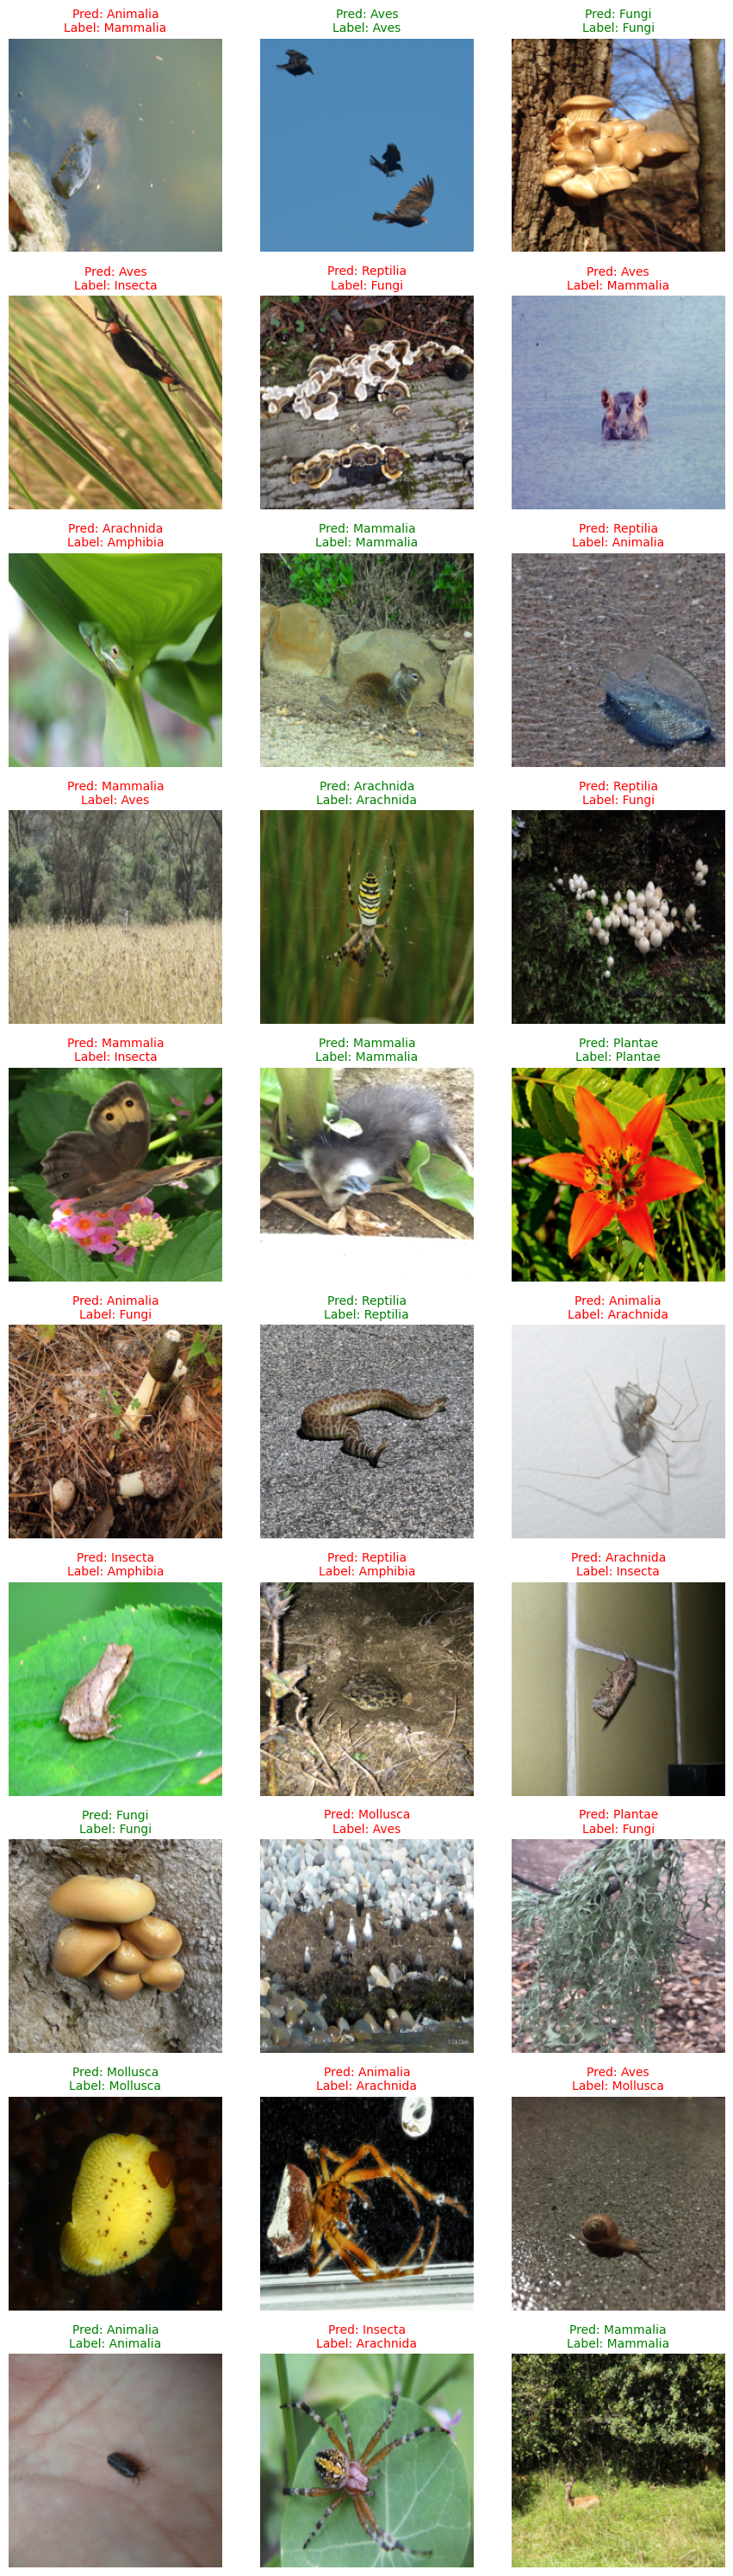

In [17]:
import random
# Denormalize
inv_transform = T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
idx_to_class = {v: k for k, v in label_map.items()}

random_indices = random.sample(range(len(all_imgs)), 30)

# 10x3 grid
fig, axes = plt.subplots(10, 3, figsize=(9, 30))
for ax, idx in zip(axes.flat, random_indices):
    img = inv_transform(all_imgs[idx]).clamp(0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    label_idx = all_labels[idx].item()
    pred_idx = all_preds[idx].item()

    label = idx_to_class[label_idx]
    pred = idx_to_class[pred_idx]

    ax.imshow(img_np)
    ax.axis("off")
    color = "green" if pred == label else "red"
    ax.set_title(f"Pred: {pred}\nLabel: {label}", color=color, fontsize=10)


plt.tight_layout()
plt.savefig("test_preds.png")

# Log to W&B
wandb.init(project="DA6401 Assignments", name="Best Model")
wandb.log({
    "Best Model test accuracy": test_acc,
    "Test set predictions": wandb.Image("test_preds.png")
})


FINETUNING VGG16

In [29]:
import torch.nn as nn
from torchvision import models
from torchvision.models import vgg16



class FineTunedVGG(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        # Load pre-trained VGG model
        base_model = vgg16(pretrained=True)
        # Freeze all layers of VGG
        for param in base_model.parameters():
            param.requires_grad = False
        self.vgg = base_model
        self.fc = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.vgg(x)         # Output: [batch_size, 1000]
        x = self.fc(x)          # Output: [batch_size, 10]
        return x


In [30]:
import torch
from torch import nn
from torch.optim import Adam
import wandb

def train(model, train_loader, val_loader, test_loader, device, epochs=10, wandb_logging = True):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.fc.parameters(), lr=1e-3)  # ✅ only train custom layers

    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch+1}: ")
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / total

        val_loss, val_acc = evaluate(model, val_loader, device, criterion)
        test_acc = get_test_acc(model, test_loader, device)
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        if wandb_logging:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "test_accuracy": test_acc
            })

def get_test_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) 

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) 
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [31]:
import torch

model = FineTunedVGG(num_classes = 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_loader, val_loader, test_loader, _ = get_data_loaders('/kaggle/working/train.csv', '/kaggle/working/val.csv', seed= 7)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


label
Arachnida    200
Aves         200
Mammalia     200
Animalia     200
Plantae      200
Reptilia     200
Mollusca     200
Insecta      200
Amphibia     200
Fungi        200
Name: count, dtype: int64
Train dataset size: 7999
Validation dataset size: 2000
Test dataset size: 2000


In [ ]:
with wandb.init(project="DA6401 Assignments", name="VGG 16 Fine tuned"):
    train(model, train_loader, val_loader, test_loader, device, 10, True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1: 
Train Loss: 1.1119, Acc: 0.6306 | Val Loss: 0.9319, Acc: 0.6840
Epoch 2: 
